# Modeling elections

In [1]:
import numpy as np
import scipy.stats as sts
import matplotlib.pyplot as plt
import pystan

## Data

The `electoral_votes` variable is a dictionary containing the number of Electoral College votes for each state. For example
```
  >>> electoral_votes['Indiana']
  11
```
Data from [Wikipedia: United_States_Electoral_College](https://en.wikipedia.org/wiki/United_States_Electoral_College)

The `survey_results` variable is a dictionary mapping from states to an array of survey results for each candidate. Each row in a survey results array represents one survey and each column represents one candidate. There are 3 columns, representing Trump (Republican), Biden (Democrat), and Other in that order. In the example below, Trump got 340 votes in the first survey, Biden got 258, and Other got 40.
```
  >>> survey_results['Indiana']
  array([[340, 258,  40],
         [240, 155,  10],
         [235, 155,  70],
         [308, 266,  84],
         [222, 161, 110]])
```
Data from [Wikipedia: Statewide opinion polling for the 2020 United States presidential election](https://en.wikipedia.org/wiki/Statewide_opinion_polling_for_the_2020_United_States_presidential_election)


In [2]:
electoral_votes = {
    'Alabama': 9,
    'Alaska': 3,
    'Arizona': 11,
    'Arkansas': 6,
    'Colorado': 9,
}

survey_results = {
    'Alabama': np.array([[611, 397, 0, 0], [799, 528, 0, 0], [793, 403, 0, 0], [288, 264, 0, 0], [353, 219, 0, 0], [997, 554, 0, 0], [312, 232, 0, 0], [409, 227, 0, 0], [319, 234, 0, 0]]),
    'Alaska': np.array([[348, 320, 0, 0], [298, 253, 0, 0], [283, 277, 0, 0], [269, 198, 0, 0], [227, 177, 0, 0], [442, 389, 0, 0], [519, 486, 0, 0], [325, 318, 0, 0], [84, 74, 0, 0]]),
    'Arizona': np.array([[522, 478, 22, 0], [313, 356, 7, 7], [291, 304, 0, 0], [270, 288, 0, 0], [236, 264, 16, 0], [180, 184, 0, 0], [133, 151, 0, 0], [269, 321, 20, 0], [230, 250, 5, 0], [3337, 3621, 0, 0], [360, 392, 0, 0], [235, 235, 0, 0], [364, 396, 8, 0], [383, 409, 9, 9], [221, 216, 0, 0], [113, 128, 0, 0], [284, 278, 0, 0], [168, 212, 0, 0], [258, 270, 0, 0], [260, 266, 0, 0], [359, 402, 9, 0], [185, 202, 17, 0], [261, 320, 26, 0], [519, 584, 0, 0], [328, 342, 0, 0], [487, 520, 0, 0], [252, 312, 0, 0], [752, 768, 0, 0], [414, 441, 0, 0], [212, 230, 0, 0], [357, 398, 0, 8], [309, 378, 23, 0], [3357, 3034, 0, 0], [396, 490, 0, 0], [162, 169, 0, 0], [325, 402, 9, 9], [445, 426, 0, 0], [311, 350, 0, 0], [188, 193, 0, 0], [466, 456, 30, 0], [271, 295, 0, 0], [204, 192, 0, 0], [522, 547, 24, 12], [2547, 2348, 0, 0], [164, 172, 0, 0], [381, 445, 0, 0], [393, 428, 0, 0], [326, 395, 17, 9], [372, 413, 0, 0], [432, 470, 0, 0], [315, 343, 0, 0], [155, 176, 0, 0], [500, 500, 0, 0], [264, 294, 0, 0], [1230, 1088, 0, 0], [270, 282, 0, 0], [137, 159, 0, 0], [258, 237, 0, 0], [337, 372, 17, 9], [266, 312, 0, 0], [616, 670, 0, 0], [88, 90, 0, 0], [421, 461, 0, 0], [148, 145, 0, 0], [368, 353, 0, 0], [180, 188, 0, 0], [388, 426, 0, 0], [258, 300, 0, 0], [230, 235, 0, 0], [258, 312, 0, 0]]),
    'Arkansas': np.array([[478, 293, 0, 0], [462, 220, 0, 0], [493, 239, 0, 0], [209, 135, 0, 0], [408, 391, 0, 0]]),
    'Colorado': np.array([[408, 510, 0, 0], [1114, 1549, 0, 0], [283, 322, 0, 0], [320, 400, 0, 0], [312, 400, 32, 8], [978, 1359, 0, 0], [262, 325, 0, 0], [252, 306, 0, 0], [246, 307, 0, 0], [246, 306, 0, 0], [240, 312, 0, 0], [935, 1355, 0, 0], [240, 320, 0, 0], [246, 306, 0, 0], [365, 481, 0, 0], [328, 470, 0, 0], [457, 620, 0, 0], [240, 286, 0, 0], [280, 371, 0, 0], [216, 330, 0, 0], [133, 201, 0, 0]]),
}

for key, value in survey_results.items():
    survey_results[key] = np.concatenate((value[:,:2], value[:,2:3] + value[:,3:4]), axis=1)

states = sorted(survey_results.keys())
print('Modeling', len(states), 'states with', sum(electoral_votes[s] for s in states), 'electoral college votes')

Modeling 5 states with 38 electoral college votes


## Generative model

1. For each state we generate an $\vec{\alpha}$ vector, which defines a Dirichlet distribution over the proportion of votes that go to each of the 3 candidates whenever we do a survey – including the final survey, namely the election itself which we want to predict. The prior over each component of $\vec{\alpha}$ is taken as a Cauchy distribution with location 0 and scale 1. Since the components of $\vec{\alpha}$ are positive, we actually use the positive half-Cauchy distribution.

2. For each survey in a state we generate a probability vector $\vec{p_i} \sim \text{Dirichlet}(\vec{\alpha})$ for the probability that a voter selects each of the 3 candidates.

3. For each survey, we then generate the number of votes going to each candidate as $\vec{k_i} \sim \text{Multinomial}(\vec{p_i})$.

### Tasks

* Use Stan to sample from the posterior distribution over $\alpha$ and visualize your results. There are 5 states, so you will have 5 posteriors.
* The posteriors over $\alpha$ show a lot of variation between different states. Explain the results you get in terms of the model and the data.

In [49]:
stan_code = '''

data {
    int<lower=1> C; // number of canidates in the multinomial
    
    int<lower=1> survey_count; // number of surveys
    int counts[survey_count, C];     // the data set: counts for each canidate
}

parameters {
    simplex[C] theta;  // the probability vector over categories
    vector[C] alpha; 
}

model {
    for (i in 1:survey_count) {
        alpha ~ cauchy(0, 1);
        theta ~ dirichlet(alpha);
        counts[i] ~ multinomial(theta);
    }
}
'''

stan_model = pystan.StanModel(model_code=stan_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a NOW.


In [50]:
# Results for one state
stan_data = {
    'C': 3,
    'survey_count': len(survey_results['Colorado']),
    'counts': survey_results['Colorado']}
results = stan_model.sampling(data=stan_data)
print(results)

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.43  5.3e-5 3.5e-3   0.42   0.42   0.43   0.43   0.43   4378    1.0
theta[2]   0.57  5.3e-5 3.5e-3   0.56   0.57   0.57   0.57   0.58   4336    1.0
theta[3] 1.2e-3  3.7e-6 2.6e-4 7.9e-4 1.0e-3 1.2e-3 1.4e-3 1.8e-3   4905    1.0
alpha[1]   0.54  1.8e-3   0.11   0.34   0.46   0.53   0.61   0.79   3960    1.0
alpha[2]    0.6  2.1e-3   0.13   0.37   0.51   0.59   0.67   0.86   3772    1.0
alpha[3]   0.15  5.0e-4   0.03   0.09   0.13   0.15   0.17   0.22   4149    1.0
lp__     -1.3e4    0.04   1.59 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1933    1.0

Samples were drawn using NUTS at Wed Feb 24 17:31:13 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

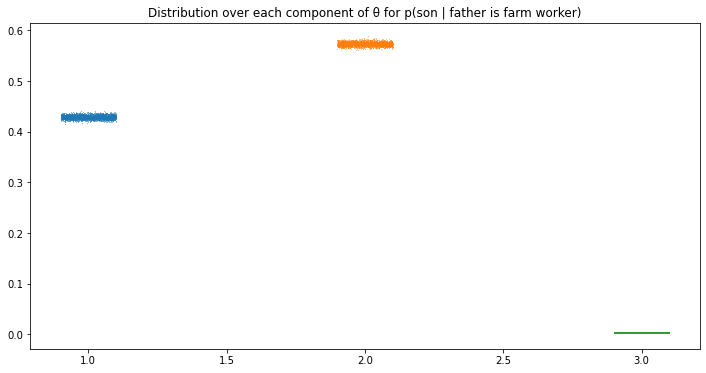

In [59]:
samples = results.extract()
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i], ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

## Simulation time

Use the posterior samples to predict the outcome of the presidential elections.

* Predict the probability that each candidate will win each state.
   * Use the posterior $\alpha$ samples to generate posterior predictive samples for $p$ – the proportion of votes each candidate would get in each state in an election.
   * Use these $p$ samples to estimate the probability that each candidate will win each state.
* Predict the probability that each candidate will win the presidential election.
   * Use the posterior predictive probability that each candidate will win each state to generate samples over the total number Electoral College votes each candidate would get in an election.
   * Use the total number of votes to generate samples over who would win the election.

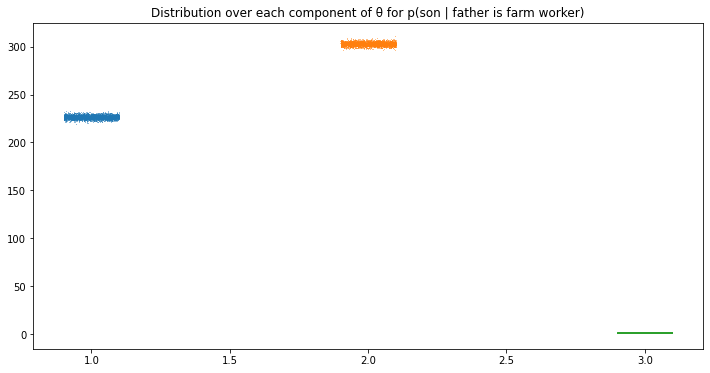

In [60]:
total_votes=528
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i]*total_votes, ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

In [61]:
# Make a new array with same dimensions as alpha
p_predicted = np.empty(samples['alpha'].shape)
     # Generate one p sample for each alpha sample
for i in range(samples['alpha'].shape[0]):
    p_predicted[i] = sts.dirichlet(samples['alpha'][i]).rvs()

In [62]:
p_predicted

array([[0.60548181, 0.39115745, 0.00336074],
       [0.00175813, 0.7809547 , 0.21728716],
       [0.76812671, 0.0617958 , 0.17007749],
       ...,
       [0.78875078, 0.17535185, 0.03589736],
       [0.01689598, 0.24148669, 0.74161734],
       [0.97190894, 0.01106953, 0.01702154]])

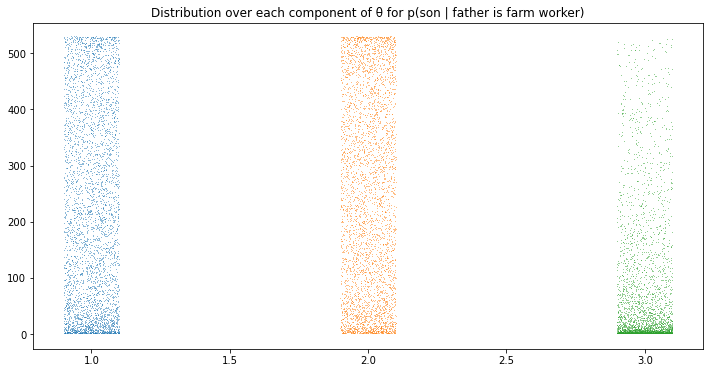

In [64]:
plt.figure(figsize=(12, 6))
for i in range(3):
    plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=p_predicted.shape[0]), p_predicted[:,i]*total_votes, ',', alpha=0.5)
plt.title('Distribution over each component of θ for p(son | father is farm worker)')
plt.show()

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.63  6.8e-4  3.1e-3    0.62    0.63    0.63    0.63    0.63     21   1.16
theta[2]    0.37  6.8e-4  3.1e-3    0.37    0.37    0.37    0.37    0.38     21   1.16
theta[3] 5.9e-17     nan 1.3e-17 5.6e-17 5.6e-17 5.6e-17 5.6e-17 1.1e-16    nan   1.16
alpha[1]    0.57    0.06    0.18    0.26    0.47    0.52    0.69    0.99     10   1.26
alpha[2]    0.52    0.03    0.16    0.24     0.4    0.54    0.59    0.89     32   1.09
alpha[3]    0.03  8.3e-4  7.4e-3    0.02    0.02    0.03    0.03    0.05     81   1.03
lp__       -5046    0.67    1.73   -5050   -5047   -5045   -5045   -5044      7   1.27

Samples were drawn using NUTS at Wed Feb 24 20:04:35 2021.
For each parameter, n_eff is a crude measure of effecti

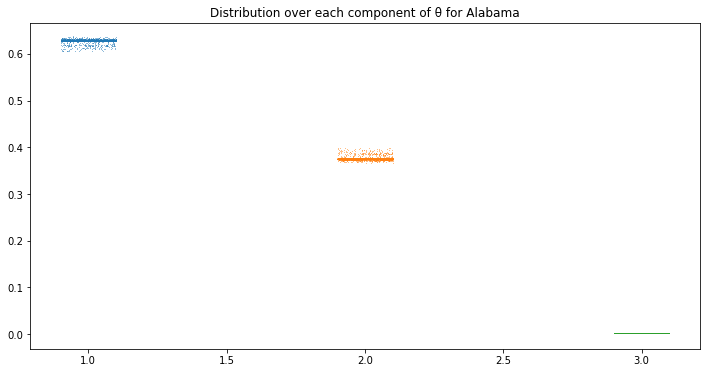

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.53  2.4e-3  7.3e-3    0.51    0.52    0.53    0.53    0.54     10   1.28
theta[2]    0.47  2.4e-3  7.3e-3    0.46    0.47    0.47    0.48    0.49     10   1.28
theta[3] 1.1e-16     nan 1.4e-17 1.1e-16 1.1e-16 1.1e-16 1.1e-16 1.1e-16    nan   1.04
alpha[1]    0.59    0.03    0.17    0.27    0.47    0.58    0.71    0.96     37   1.07
alpha[2]    0.58    0.08    0.24    0.24    0.41    0.55     0.7    1.13      9   1.59
alpha[3]    0.03  9.0e-4  8.8e-3    0.01    0.02    0.03    0.03    0.05     96   1.03
lp__       -3415    0.23     1.5   -3418   -3416   -3415   -3414   -3413     44   1.09

Samples were drawn using NUTS at Wed Feb 24 20:05:59 2021.
For each parameter, n_eff is a crude measure of effecti

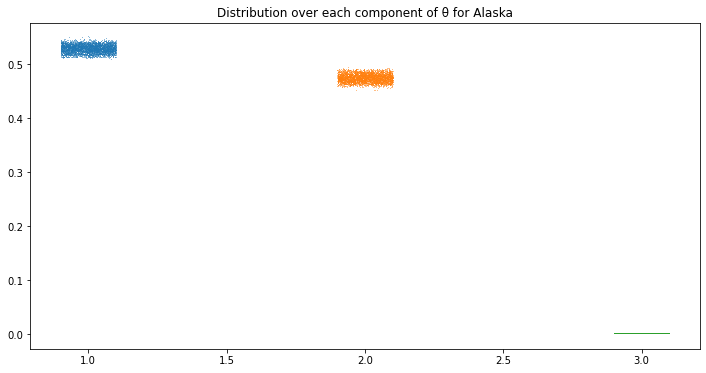

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.49  2.9e-5 2.0e-3   0.48   0.49   0.49   0.49   0.49   4695    1.0
theta[2]   0.51  2.9e-5 2.0e-3    0.5   0.51   0.51   0.51   0.51   4717    1.0
theta[3] 4.2e-3  3.8e-6 2.5e-4 3.7e-3 4.0e-3 4.2e-3 4.4e-3 4.7e-3   4381    1.0
alpha[1]   0.55  1.0e-3   0.06   0.44   0.51   0.55    0.6   0.69   4077    1.0
alpha[2]   0.56  1.0e-3   0.07   0.44   0.52   0.56   0.61    0.7   4300    1.0
alpha[3]   0.18  3.1e-4   0.02   0.14   0.16   0.18   0.19   0.22   4507    1.0
lp__     -4.5e4    0.03   1.57 -4.5e4 -4.5e4 -4.5e4 -4.5e4 -4.5e4   2226    1.0

Samples were drawn using NUTS at Wed Feb 24 20:06:04 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

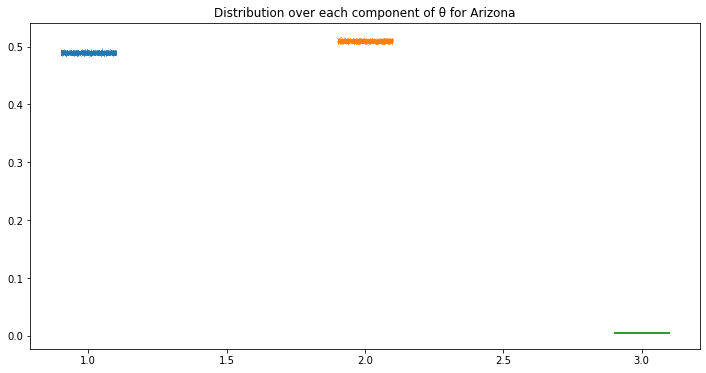

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

            mean se_mean      sd    2.5%     25%     50%     75%   97.5%  n_eff   Rhat
theta[1]    0.63  1.7e-3  6.8e-3    0.61    0.63    0.63    0.63    0.64     16   1.38
theta[2]    0.37  1.7e-3  6.8e-3    0.36    0.37    0.37    0.37    0.39     16   1.38
theta[3] 6.6e-17 5.3e-18 2.4e-17 5.6e-17 5.6e-17 5.6e-17 5.6e-17 1.1e-16     21   1.25
alpha[1]     0.7    0.06     0.3    0.26    0.47    0.66    0.88    1.36     25   1.17
alpha[2]    0.58    0.07    0.25    0.21    0.39    0.55    0.71    1.17     12   1.34
alpha[3]    0.03  2.0e-3    0.01    0.01    0.02    0.03    0.04    0.06     42   1.11
lp__       -2098    0.36    1.83   -2102   -2099   -2098   -2097   -2095     27   1.17

Samples were drawn using NUTS at Wed Feb 24 20:07:11 2021.
For each parameter, n_eff is a crude measure of effecti

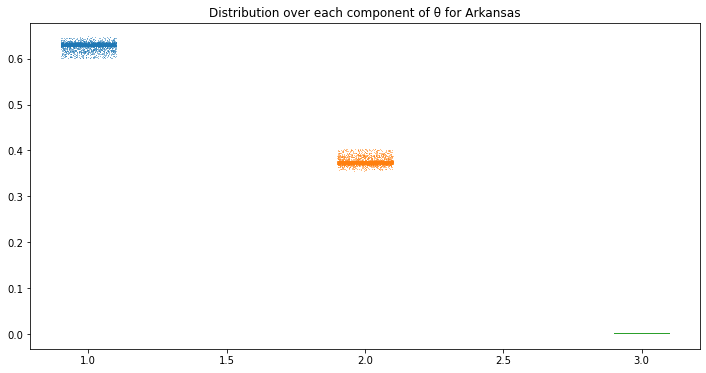

Inference for Stan model: anon_model_1ee154ee409ce8d04ab5dc23fb7e2b0a.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
theta[1]   0.43  5.4e-5 3.5e-3   0.42   0.42   0.43   0.43   0.43   4264    1.0
theta[2]   0.57  5.4e-5 3.5e-3   0.56   0.57   0.57   0.57   0.58   4259    1.0
theta[3] 1.2e-3  4.0e-6 2.6e-4 7.6e-4 1.0e-3 1.2e-3 1.4e-3 1.8e-3   4227    1.0
alpha[1]   0.54  1.9e-3   0.12   0.34   0.46   0.53   0.61    0.8   4010    1.0
alpha[2]    0.6  2.1e-3   0.13   0.37   0.51   0.59   0.68   0.88   3860    1.0
alpha[3]   0.15  5.3e-4   0.03   0.09   0.13   0.15   0.17   0.23   4160    1.0
lp__     -1.3e4    0.04   1.66 -1.3e4 -1.3e4 -1.3e4 -1.3e4 -1.3e4   1808    1.0

Samples were drawn using NUTS at Wed Feb 24 20:07:13 2021.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reductio

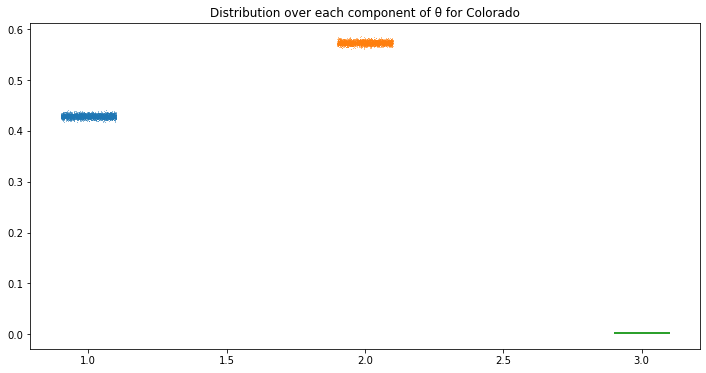

In [65]:
# All states
for state in survey_results.keys():
    # Results for one state
    stan_data = {
        'C': 3,
        'survey_count': len(survey_results[state]),
        'counts': survey_results[state]}
    results = stan_model.sampling(data=stan_data)
    print(results)
    samples = results.extract()
    plt.figure(figsize=(12, 6))
    for i in range(3):
        plt.plot(sts.uniform.rvs(loc=i+1-0.1, scale=0.2, size=samples['theta'].shape[0]), samples['theta'][:,i], ',', alpha=0.5)
    plt.title(f'Distribution over each component of θ for {state}')
    plt.show()